# ASI Notebook Template
### Description:

# Setup

### Install Packages

Uncomment anything you need to install (first time uncomment everything). This will install these Python libraries into your environent so only needed once per machine (or install).

In [17]:
# You may needs these - should only need to uncomment and run once
# !pip install msgpack
!pip install Kqlmagic --no-cache-dir  --upgrade
# # May not need this if KqlMagic is installed
# !pip install azure.kusto.data --upgrade
# !conda install -c conda-forge python-levenshtein -y
# !pip install bokeh
# !pip install holoviews
# !pip install seaborn
# !pip install pythonnet

Requirement already up-to-date: Kqlmagic in c:\users\ianhelle\appdata\local\continuum\anaconda3\lib\site-packages (0.1.82)
Requirement not upgraded as not directly required: prettytable>=0.7.2 in c:\users\ianhelle\appdata\local\continuum\anaconda3\lib\site-packages (from Kqlmagic) (0.7.2)
Requirement not upgraded as not directly required: Markdown in c:\users\ianhelle\appdata\local\continuum\anaconda3\lib\site-packages (from Kqlmagic) (3.0.1)
Requirement not upgraded as not directly required: seaborn>=0.9.0 in c:\users\ianhelle\appdata\local\continuum\anaconda3\lib\site-packages (from Kqlmagic) (0.9.0)
Requirement not upgraded as not directly required: ipython>=7.0.1 in c:\users\ianhelle\appdata\local\continuum\anaconda3\lib\site-packages (from Kqlmagic) (7.0.1)
Requirement not upgraded as not directly required: requests>=2.19.1 in c:\users\ianhelle\appdata\local\continuum\anaconda3\lib\site-packages (from Kqlmagic) (2.19.1)
Requirement not upgraded as not directly required: traitlets 

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Imports and Magic

In [18]:
# Javascript control to hide/display code cells.
# 'toggle_code()' somewhere in a cell to use this
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show/Hide Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))


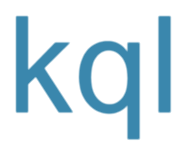

<IPython.core.display.Javascript object>

In [19]:
#Imports
from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.exceptions import KustoServiceError

import numpy as np
import scipy.linalg as lin
import Levenshtein as leven
from IPython import get_ipython
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive, Layout, Select, IntSlider

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import itertools
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

# KqlMagic
%reload_ext Kqlmagic
%config Kqlmagic.auto_dataframe=True

### KqlMagic
Documentation https://github.com/mbnshtck/jupyter-kql-magic/blob/master/README.rst

Quickstart Notebook https://github.com/mbnshtck/jupyter-kql-magic/blob/master/notebooks/QuickStart.ipynb

In [20]:
# Kusto utility functions
# Allows printing of query with stripped commments and newline chars
def print_kql(query):
    print(clean_kql_query(query))

def clean_kql_query(query_string):
    import re
    return re.sub(r'(//[^\"\'\n]+)', '', query_string, re.MULTILINE).replace('\n', '').strip()

def execute_kql_query(query_string):
    if not query_string or len(query_string.strip()) == 0:
        print('No query supplied')
        return None
    src_query = clean_kql_query(query_string)
    magic_string = f'results_frame << {src_query}'
    magic_string = magic_string
    ip = get_ipython()
    ip.run_line_magic('kql', magic_string)
    return results_frame

In [27]:
# Select a LA workspace id from some demo environments
from ipywidgets import widgets, Select, Layout, interactive
available_workspaces = {'ASIHuntOMSWorkspaceV4': '52b1ab41-869e-4138-9e40-2a4457f09bf0',
                        'ASIHuntOMSWorkspaceV5': '4ca7b24a-6e8f-4540-a8ce-1a80c2948c37',
                        'Contoso77':'802d39e1-9d70-404d-832c-2de5e2478eda', 
                        'MSTICLinux':'06dc719f-5dad-47e9-b5af-07d84a0bda4e',
                        'Rome ILDC - Detection E2E Tests Stage': '3eb61071-5dcd-4db3-94fa-0091a69b7359'}

alertId = ''
def select_workspace(x=''):
    global workspace_id
    workspace_id = available_workspaces[x]
     
selected_workspace = widgets.Select(options=available_workspaces.keys(), 
                              description='Select workspace :',
                              layout=Layout(width='50%', height='100px'),
                              style = {'description_width': 'initial'})
interactive(select_workspace, x=selected_workspace)

interactive(children=(Select(description='Select workspace :', layout=Layout(height='100px', width='50%'), opt…

In [34]:
# Kusto authentication
#%kql kusto://code().cluster('Ascprodus').database('ProdAlerts')
    
# Log Analytics authentication
%kql loganalytics://code().workspace(workspace_id)

In [23]:
#Table and schema mapping to make it consistent with Kusto
# Query setup for LogAnalytics
security_alert_source = 'SecurityAlert'
security_alert_project = '''| project 
TenantId,
StartTimeUtc = StartTime,
EndTimeUtc = EndTime,
ProviderAlertId = VendorOriginalId,
SystemAlertId,
ProviderName,
VendorName,
AlertType = Type,
AlertName,
AlertDisplayName = DisplayName,
Description,
Severity = AlertSeverity,
IsIncident,
ExtendedProperties,
Entities,
ConfidenceLevel,
ConfidenceScore,
ExtendedLinks,
WorkspaceSubscriptionId,
WorkspaceResourceGroup,
TimeGenerated,
ResourceId,
SourceComputerId '''
# //CompromisedEntity,

proc_create_eventsource = 'SecurityEvent | where EventID == 4688'
process_create_project = '''| project 
TenantId,
Account,
EventID,
TimeGenerated,
Computer,
SubjectUserSid,
SubjectUserName,
SubjectDomainName,
SubjectLogonId,
NewProcessId,
NewProcessName,
TokenElevationType,
ProcessId,
CommandLine,
ParentProcessName,
TargetLogonId,
SourceComputerId
| extend TimeCreatedUtc=TimeGenerated '''

# Alerts

### Sample queries to get list of alerts for a specified window

In [29]:
get_alerts_count_tmplt = '''
{table}
| where StartTime > ago({lookback}h) 
{query_project}
| summarize alertCount=count(), firstAlert=min(StartTimeUtc), lastAlert=max(StartTimeUtc) by AlertName
| order by alertCount desc
'''.format(table = security_alert_source, query_project=security_alert_project, lookback = '{lookback}')


get_alerts_tmplt ='''
{table}
| where StartTime > ago({lookback}h)
{query_project}
| extend extendedProps = parse_json(ExtendedProperties) 
| extend CompromisedEntity = tostring(extendedProps['Compromised Host'])
| project-away extendedProps
'''.format(table = security_alert_source, query_project=security_alert_project, lookback = '{lookback}' )

from ipywidgets import interactive, Layout, IntSlider

alertLookbackHours = widgets.IntSlider(value=4, min=1, max=240, step=1,
    description='Select time to look back for alerts:', layout=Layout(width='60%', height='50px'),style = {'description_width': 'initial'})
display(alertLookbackHours)

IntSlider(value=4, description='Select time to look back for alerts:', layout=Layout(height='50px', width='60%…

In [36]:
get_alerts_count_query = get_alerts_count_tmplt.format(lookback = alertLookbackHours.value)
get_alerts_query = get_alerts_tmplt.format(lookback = alertLookbackHours.value)

alert_counts = execute_kql_query(get_alerts_count_query)
last_alerts = execute_kql_query(get_alerts_query)
display(alert_counts)
display(last_alerts)

,AlertName,alertCount,firstAlert,lastAlert
0,Suspicious Account Added,1,2018-12-06 19:18:10,2018-12-06 19:18:10
1,Alert for Account Not Found,1,2018-12-06 21:17:01,2018-12-06 21:17:01


,TenantId,StartTimeUtc,EndTimeUtc,ProviderAlertId,SystemAlertId,ProviderName,VendorName,AlertType,AlertName,AlertDisplayName,Description,Severity,IsIncident,ExtendedProperties,Entities,ConfidenceLevel,ConfidenceScore,ExtendedLinks,WorkspaceSubscriptionId,WorkspaceResourceGroup,TimeGenerated,ResourceId,SourceComputerId,CompromisedEntity
0,802d39e1-9d70-404d-832c-2de5e2478eda,2018-12-06 19:18:10,2018-12-06 20:18:10,a38c4128-e99b-4140-a418-07d6ac6f0346,3ec96585-07ef-4087-8ac7-b7c90b8c1193,CustomAlertRule,Alert Rule,SecurityAlert,Suspicious Account Added,Suspicious Account Added,Account added and removed from group within 24h,Medium,False,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subscriptions/3c1bb38c-82e3-4f8d-a115-a7110ba70d05/resourcegroups/contoso77/providers/microsoft.operation...",,Unknown,NaN,,3c1bb38c-82e3-4f8d-a115-a7110ba70d05,contoso77,2018-12-06 20:28:14,,,
1,802d39e1-9d70-404d-832c-2de5e2478eda,2018-12-06 21:17:01,2018-12-06 22:17:01,e8f5218f-7b2f-4a74-9d85-9c2807dc3f7d,5d5a5265-b920-40ea-ac94-a0fd3549b92b,CustomAlertRule,Alert Rule,SecurityAlert,Alert for Account Not Found,Alert for Account Not Found,Alert for Account Not Found,Medium,False,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subscriptions/3c1bb38c-82e3-4f8d-a115-a7110ba70d05/resourcegroups/contoso77/providers/microsoft.operation...",,Unknown,NaN,,3c1bb38c-82e3-4f8d-a115-a7110ba70d05,contoso77,2018-12-06 22:27:06,,,


In [37]:
# Functions to Fetch and Display alert
def fetch_alert(alertproviderId, local_cache=None):
    
    if local_cache is not None:
        alerts = local_cache[local_cache['ProviderAlertId'] == alertproviderId]
    else:
        # Get alert
        getAlertQuery = f'{get_alerts_query} | where ProviderAlertId == \'{alertproviderId}\''
        alerts = execute_kql_query(getAlertQuery)
        
    if alerts.shape[0] > 0:
        investigatedAlert = pd.Series(alerts.iloc[0])
        if isinstance(investigatedAlert['ExtendedProperties'], str):
            investigatedAlert['ExtendedProperties'] = json.loads((investigatedAlert['ExtendedProperties']))
        if isinstance(investigatedAlert['Entities'], str) and len(investigatedAlert['Entities']) > 0:
            investigatedAlert['Entities'] = json.loads((investigatedAlert['Entities']))
        return investigatedAlert
    
def display_alert(investigatedAlert=None):
    if investigatedAlert is not None:
        # Display raw properties
        print(investigatedAlert)
        if "ExtendedProperties" in investigatedAlert:
            print("ExtendedProperties:")
            for k,v in investigatedAlert['ExtendedProperties'].items():
                print('\t', k, ': ', v)
        if 'Entities' in investigatedAlert:
            print("Entities:")
            for e in investigatedAlert['Entities']:
                print('\t', e)
                
# Select and view alert
from ipywidgets import interactive, Layout
 
items = last_alerts.sort_values('ProviderAlertId')['ProviderAlertId'].unique().tolist()

alertId = ''
def view_alert(x=''):
    global investigatedAlert
    global alertId
    alertId = x
    print('AlertId:', x, '\n')
    investigatedAlert = fetch_alert(x, local_cache=last_alerts)
    display_alert(investigatedAlert)
    
 
selected_alert = widgets.Select(options=items, 
                              description='Select alert :',
                              layout=Layout(width='50%', height='200px'),
                              style = {'description_width': 'initial'})
interactive(view_alert, x=selected_alert)                

interactive(children=(Select(description='Select alert :', layout=Layout(height='200px', width='50%'), options…

# Hunting Queries
Note: download the queries to a local folder (under your notebooks root folder) and change 
**hunting_query_root** to point to that folder

In [42]:
# Read in  the queries
import os
from os import path, listdir
hunting_query_root = './test/ASI/Hunting Queries'
hunting_queries = dict()
for folder in listdir(hunting_query_root):
    query_sub_cat = dict()
    if not path.isdir(path.join(hunting_query_root, folder)):
        continue
        
    q_files = listdir(path.join(hunting_query_root, folder))
    for q_file in q_files:
        file_path = path.join(hunting_query_root, folder, q_file)
        with open(file_path) as f:
            query_contents = f.readlines()
            query_name = q_file.replace('.txt', '')
            query_sub_cat[query_name] = ''.join(query_contents)
    hunting_queries[folder] = query_sub_cat

# Widgets to display queries by category
sub_cats_w = widgets.Select(options=hunting_queries.keys(), 
                              description='Subcategory :',
                              layout=Layout(width='30%', height='120px'),
                              style = {'description_width': 'initial'})

queries_w = widgets.Select(options = hunting_queries[list(hunting_queries.keys())[0]].keys(),
                           description='Query :    ',
                           layout=Layout(width='30%', height='120px'),
                           style = {'description_width': 'initial'})

query_text_w = widgets.Textarea(
    value='',
    description='Query:',
    layout=Layout(width='100%', height='150px', visiblity='hidden'),
    disabled=False)

def on_cat_value_change(change):
    queries_w.options = hunting_queries[change['new']].keys()
    queries_w.value = list(hunting_queries[change['new']].keys())[0]

def on_query_value_change(change):
    if view_qry_check.value:
        query_text_w.value = hunting_queries[sub_cats_w.value][queries_w.value]
    
def on_view_query_value_change(change):
    if change.new:
        on_query_value_change(None)
        query_text_w.layout.visibility = 'visible'
    else:
        query_text_w.value = ''
        query_text_w.layout.visibility = 'hidden'

query_text_w.layout.visibility = 'hidden'
sub_cats_w.observe(on_cat_value_change, names='value')
queries_w.observe(on_query_value_change, names='value')
view_qry_check = widgets.Checkbox(description="View query..", value=False)
view_qry_check.observe(on_view_query_value_change, names='value')

# view_qry_button.on_click(click_exec_hqry)
# display(exec_hqry_button);

hbox = widgets.HBox([sub_cats_w, queries_w, view_qry_check])
vbox = widgets.VBox([hbox, query_text_w])
display(vbox)

In [44]:
# Execute the hunting query
from IPython.display import clear_output

def click_exec_hqry(b):
    global hunting_qry_results
    query_name = queries_w.value
    query_cat = sub_cats_w.value
    query_text = hunting_queries[query_cat][query_name]
    clear_output()
    display(exec_hqry_button);
    print('Running query...')
    hunting_qry_results = execute_kql_query(query_text)
    display(hunting_qry_results)
   
exec_hqry_button = widgets.Button(description="Execute query..")
exec_hqry_button.on_click(click_exec_hqry)
display(exec_hqry_button);

Button(description='Execute query..', style=ButtonStyle())

Running query...


,EventTime,ComputerName,AccountName,AccountDomain,FileName,ProcessCommandLine,InitiatingProcessFileName,InitiatingProcessCommandLine,InitiatingProcessParentFileName
0,2018-12-07 04:33:02.007,DHCPContoso77,DHCPContoso77$,WORKGROUP,cscript.exe,"""C:\Windows\system32\cscript.exe"" /nologo ""MonitorKnowledgeDiscovery.vbs""",C:\Program Files\Microsoft Monitoring Agent\Agent\MonitoringHost.exe,,
1,2018-12-07 04:33:02.017,DHCPContoso77,DHCPContoso77$,WORKGROUP,conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,C:\Windows\System32\cscript.exe,,
2,2018-12-07 04:33:52.007,ContosoAD.Contoso77.lab,ContosoAD$,CONTOSO77,cscript.exe,"""C:\Windows\system32\cscript.exe"" /nologo ""MonitorKnowledgeDiscovery.vbs""",C:\Program Files\Microsoft Monitoring Agent\Agent\MonitoringHost.exe,,
3,2018-12-07 04:33:52.013,ContosoAD.Contoso77.lab,ContosoAD$,CONTOSO77,conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,C:\Windows\System32\cscript.exe,,
4,2018-12-07 04:34:02.003,DHCPContoso77,DHCPContoso77$,WORKGROUP,cscript.exe,"""C:\Windows\system32\cscript.exe"" /nologo ""MonitorKnowledgeDiscovery.vbs""",C:\Program Files\Microsoft Monitoring Agent\Agent\MonitoringHost.exe,,
